##### IMPORT LIBRARIES

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Activation,Dense,Dropout
%matplotlib inline
import seaborn as sns 


##### IMPORT DATASET

In [ ]:
df = pd.read_csv('monthly_milk_production.csv', index_col= 'Date', parse_dates=True)
df.index.freq = 'MS'

In [ ]:
df.columns= ['Production']

In [ ]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


##### PLOT DATASET

<AxesSubplot:xlabel='Date'>

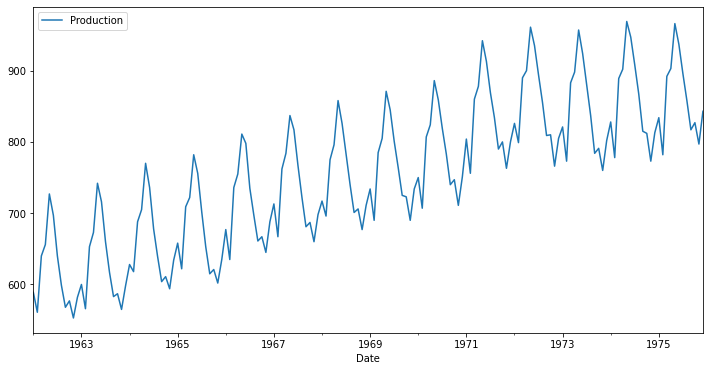

In [ ]:
df.plot(figsize=(12,6))

##### SEASONAL DECOMPOSE

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

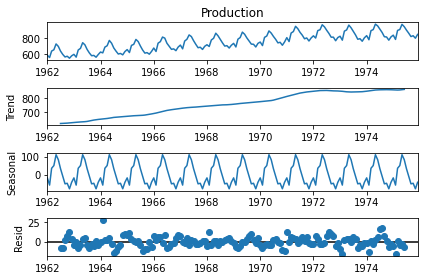

In [ ]:
result= seasonal_decompose(df['Production'])
result.plot();

In [ ]:
len(df)

168

##### TRAIN TEST DATA

In [ ]:
train = df.iloc[:156]
test= df.iloc[156:]

In [ ]:
test= test[0:12]

##### MIN MAX SCALER

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
scaled_train = scaler.transform(train)

In [ ]:
scaled_test = scaler.transform(test) 

##### TIME SERIES GENERATOR

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
len(scaled_train)

156

##### LSTM MODEL

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [ ]:
n_input = 12
n_feature = 1

train_generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input, batch_size=1)

In [ ]:
model = Sequential()

model.add(LSTM(128,activation = 'relu', input_shape= (n_input, n_feature), return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 12, 128)           66560     
                                                                 
 lstm_8 (LSTM)               (None, 12, 128)           131584    
                                                                 
 lstm_9 (LSTM)               (None, 128)               131584    
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 329,857
Trainable params: 329,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit_generator(train_generator,epochs= 50)

Epoch 1/50


<ipython-input-114-cb9c59603b9c>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator,epochs= 50)


144/144 [==============================] - 7s 19ms/step - loss: 0.0497
Epoch 2/50
144/144 [==============================] - 3s 21ms/step - loss: 0.0262
Epoch 3/50
144/144 [==============================] - 3s 23ms/step - loss: 0.0235
Epoch 4/50
144/144 [==============================] - 3s 18ms/step - loss: 0.0231
Epoch 5/50
144/144 [==============================] - 3s 19ms/step - loss: 0.0180
Epoch 6/50
144/144 [==============================] - 3s 20ms/step - loss: 0.0167
Epoch 7/50
144/144 [==============================] - 3s 20ms/step - loss: 0.0104
Epoch 8/50
144/144 [==============================] - 3s 19ms/step - loss: 0.0077
Epoch 9/50
144/144 [==============================] - 3s 22ms/step - loss: 0.0057
Epoch 10/50
144/144 [==============================] - 3s 19ms/step - loss: 0.0050
Epoch 11/50
144/144 [==============================] - 3s 20ms/step - loss: 0.0053
Epoch 12/50
144/144 [==============================] - 3s 18ms/step - loss: 0.0043
Epoch 13/50
144/144 [===

##### PLOT DATA LOSS

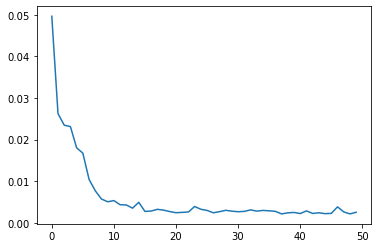

In [ ]:
my_loss= model.history.history['loss']
plt.plot(range(len(my_loss)),my_loss)

##### MODEL PREDICT

In [ ]:
first_eval_batch = scaled_train[-12:]

In [ ]:
first_eval_batch

array([[0.66105769],
       [0.54086538],
       [0.80769231],
       [0.83894231],
       [1.        ],
       [0.94711538],
       [0.85336538],
       [0.75480769],
       [0.62980769],
       [0.62259615],
       [0.52884615],
       [0.625     ]])

In [ ]:
first_eval_batch = first_eval_batch.reshape((1,n_input,n_feature))

In [ ]:
model.predict(first_eval_batch)

1/1 [==============================] - 1s 626ms/step


array([[0.68716747]], dtype=float32)

##### Forecast RNN Model

In [ ]:
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1,n_input,n_feature))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis= 1)

1/1 [==============================] - 0s 32ms/step


##### TEST PREDICT

In [ ]:
test_predictions

[array([0.68716747], dtype=float32),
 array([0.59835553], dtype=float32),
 array([0.8397768], dtype=float32),
 array([0.87817544], dtype=float32),
 array([0.99104565], dtype=float32),
 array([0.95999455], dtype=float32),
 array([0.89331174], dtype=float32),
 array([0.8021582], dtype=float32),
 array([0.6801487], dtype=float32),
 array([0.66446966], dtype=float32),
 array([0.5906808], dtype=float32),
 array([0.6630845], dtype=float32)]

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
true_predictions

array([[838.86166573],
       [801.91590118],
       [902.34715462],
       [918.32098198],
       [965.27499199],
       [952.35773468],
       [924.61768341],
       [886.69780159],
       [835.94186783],
       [829.41937828],
       [798.72320366],
       [828.84315491]])

In [ ]:
test['Predictions'] =true_predictions

In [ ]:
test.head()

,Production,Predictions
Date,,
1975-01-01,834,838.861666
1975-02-01,782,801.915901
1975-03-01,892,902.347155
1975-04-01,903,918.320982
1975-05-01,966,965.274992


##### PLOT PREDICTION

<AxesSubplot:xlabel='Date'>

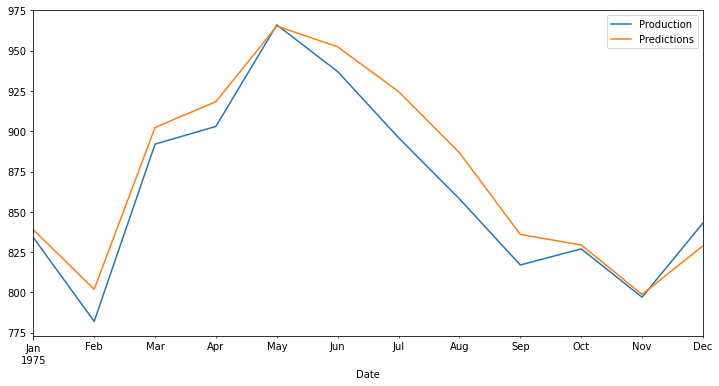

In [ ]:
test.plot(figsize=(12,6))

##### MSE

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print("MSE = ",rmse)

MSE =  16.35295519680462


##### NEXT YEAR PREDICTION 

In [ ]:
scaler = MinMaxScaler()

array = []
train_data = []
train_labels = []

for i in range(len(df)):
    array.append(df.iloc[i]['Production'])

array = np.array(array).reshape(-1,1)
array = scaler.fit_transform(array)


In [ ]:
k = 0
for i in range(len(array)):
    try:
        train_data.append(array[12*k:12*(k+1)])
        train_labels.append(array[12*(k+1)])
        k+=1
    except:
        break

##### TRAIN DATA    

In [ ]:
train_data = np.squeeze(train_data)
train_data.shape

(14, 12)

In [ ]:
train_labels = np.array(train_labels)
train_labels.shape

(13, 1)

In [ ]:
train_data = train_data[:len(train_labels)]
train_data = np.expand_dims(train_data,1)
train_data.shape

(13, 1, 12)

In [ ]:
train_data[1]

array([[0.11298077, 0.03125   , 0.24038462, 0.28846154, 0.45432692,
        0.39182692, 0.25721154, 0.15384615, 0.07211538, 0.08173077,
        0.02884615, 0.10817308]])

In [ ]:
train_labels[1]

array([0.18028846])

##### LSTM MODEL

In [ ]:
model = Sequential()
model.add(LSTM(250,input_shape=(1,12)))
model.add(Dropout(0.5))
model.add(Dense(250,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='relu'))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 250)               263000    
                                                                 
 dropout_3 (Dropout)         (None, 250)               0         
                                                                 
 dense_6 (Dense)             (None, 250)               62750     
                                                                 
 dropout_4 (Dropout)         (None, 250)               0         
                                                                 
 dense_7 (Dense)             (None, 12)                3012      
                                                                 
 dropout_5 (Dropout)         (None, 12)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                

##### FIT MODEL

In [ ]:
E = 50
H = model.fit(train_data,train_labels,epochs=E)

Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 0.2081
Epoch 2/50
1/1 [==============================] - 0s 9ms/step - loss: 0.1937
Epoch 3/50
1/1 [==============================] - 0s 11ms/step - loss: 0.1489
Epoch 4/50
1/1 [==============================] - 0s 16ms/step - loss: 0.1278
Epoch 5/50
1/1 [==============================] - 0s 13ms/step - loss: 0.1501
Epoch 6/50
1/1 [==============================] - 0s 14ms/step - loss: 0.1035
Epoch 7/50
1/1 [==============================] - 0s 11ms/step - loss: 0.0519
Epoch 8/50
1/1 [==============================] - 0s 14ms/step - loss: 0.0748
Epoch 9/50
1/1 [==============================] - 0s 15ms/step - loss: 0.0753
Epoch 10/50
1/1 [==============================] - 0s 14ms/step - loss: 0.0892
Epoch 11/50
1/1 [==============================] - 0s 14ms/step - loss: 0.0435
Epoch 12/50
1/1 [==============================] - 0s 17ms/step - loss: 0.0675
Epoch 13/50
1/1 [==============================] - 0s 15ms/step 

##### SEED ARRAY PREDICT

In [ ]:
seed = array[-12:]

In [ ]:
seed.shape

(12, 1)

In [ ]:
for _ in range(12):
    curr_12_months = seed[-12:]
    curr_12_months = np.squeeze(curr_12_months)
    curr_12_months = np.expand_dims(curr_12_months,0)
    curr_12_months = np.expand_dims(curr_12_months,0)
    pred = model.predict(curr_12_months)
    seed = np.append(seed,pred)

1/1 [==============================] - 0s 31ms/step


In [ ]:
seed

array([0.67548077, 0.55048077, 0.81490385, 0.84134615, 0.99278846,
       0.92307692, 0.82451923, 0.73317308, 0.63461538, 0.65865385,
       0.58653846, 0.69711538, 0.53001249, 0.5188899 , 0.51716042,
       0.50207698, 0.48750365, 0.46679959, 0.44201502, 0.42386344,
       0.40453634, 0.39746484, 0.37972665, 0.3750101 ])

##### NEXT YEAR PREDICTION

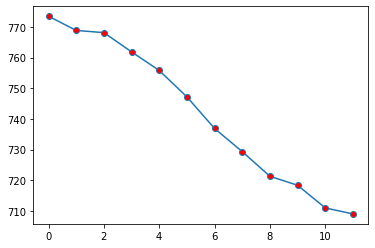

In [ ]:
next_year_prediction = scaler.inverse_transform(seed[-12:].reshape(-1,1))
plt.plot(range(0,12),next_year_prediction,marker='.',markerfacecolor='red',markersize=12)